<a href="https://colab.research.google.com/github/charlieh0tel/video_passthrough_analysis/blob/main/DigitalPassthroughV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is a very high level system analysis for a video passthrough headset. 

We'd like to come up with an initial estimate of:

*   Number of cameras required
*   System power
*   Required energy for an assumed run time
*   Battery mass and volume given the energy estimate
*   Minimum surface area needed for heat transfer


Copyright (c) 2023, Christopher Hoover

SPDX-License-Identifier: BSD-3-Clause


In [1]:
%pip install quantities

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import numpy as np
import quantities as pq

In [3]:
!git clone https://github.com/charlieh0tel/pinhole.git || git -C pinhole pull --ff
from pinhole import camera

fatal: destination path 'pinhole' already exists and is not an empty directory.
Already up to date.


In [4]:
!git clone https://github.com/charlieh0tel/engmath.git || git -C engmath pull --ff
import engmath.battery
import engmath.wearable

fatal: destination path 'engmath' already exists and is not an empty directory.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), 639 bytes | 319.00 KiB/s, done.
From https://github.com/charlieh0tel/engmath
   94c7d9a..df379fa  main       -> origin/main
Updating 94c7d9a..df379fa
Fast-forward
 Makefile        |  2 +-
 battery.py      | 12 ++++++------
 battery_test.py |  8 ++++----
 3 files changed, 11 insertions(+), 11 deletions(-)


Next, let's determine the world field of view we need to cover with the cameras.

https://www.mdpi.com/2075-5309/11/12/627#

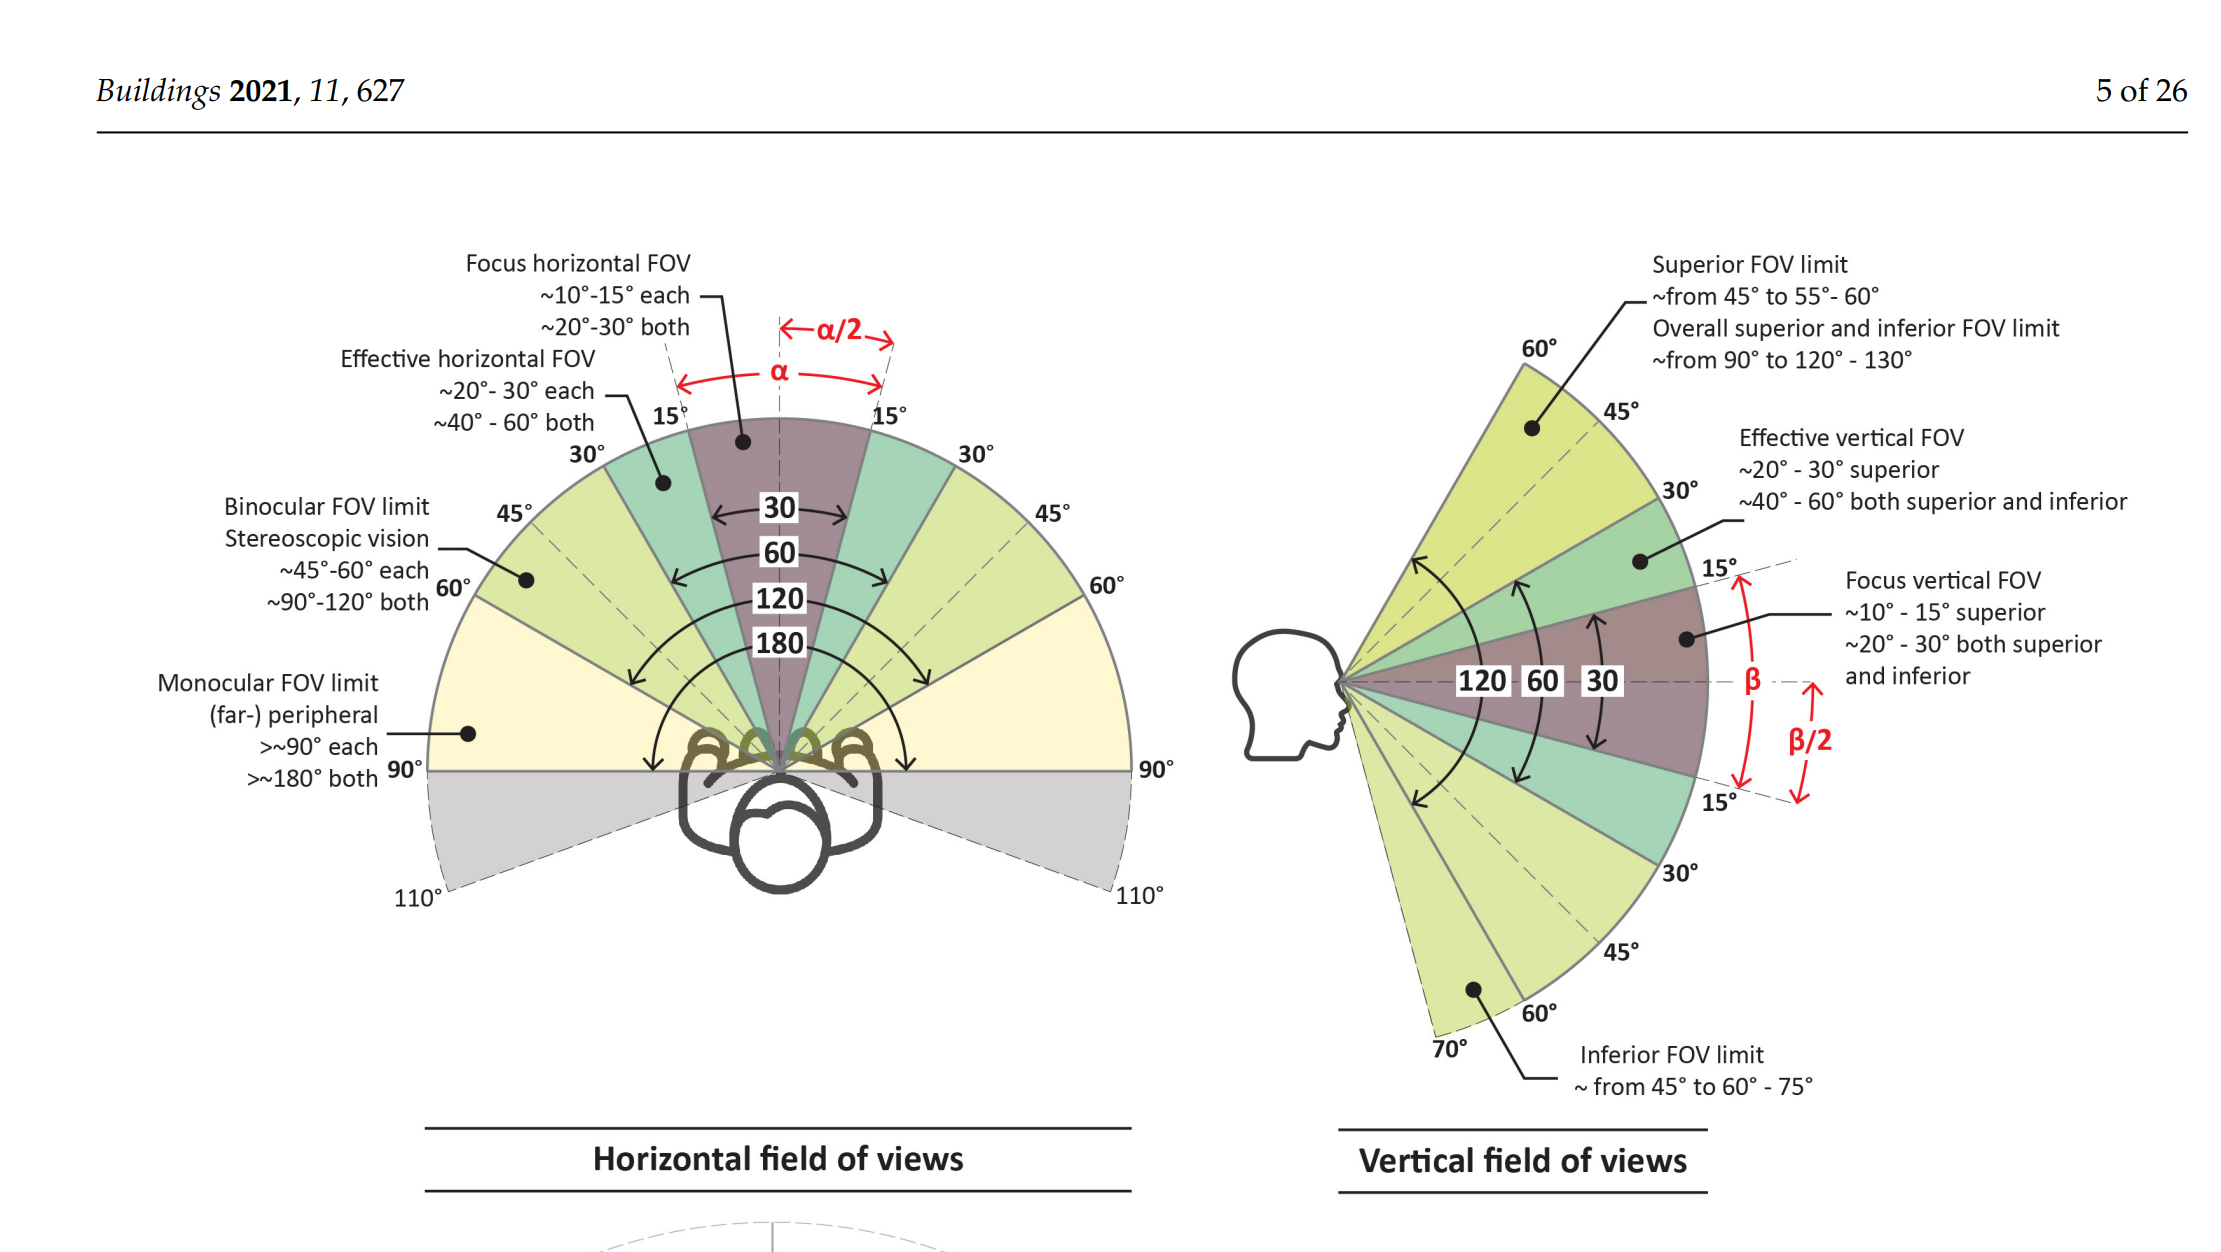

In [5]:
# Normal human FOV.
binocular_fov = (130. * pq.degrees, 120. * pq.degrees)
monocular_fov = (130. * pq.degrees, 180. * pq.degrees)

Let's assume a sensor and a lens to get started.

It might make sense to use different focal length lenses in the system.   E.g., we might wish to use a shroter f-theta lens  for the peripheral vision.  

For now, we are working with a single focal length.

In [6]:
# IMXx77-like sensor.
pitch = 1.55 * pq.micron
w_px = 4096
h_px = 3072
sensor = camera.Sensor('s', pitch, w_px, h_px)
    
# A lens to try.
focal_length = 3 * pq.mm
f_no = 2.
aperture_diameter = focal_length / f_no
lens = camera.Lens('l', focal_length, aperture_diameter, projection='rectilinear')
kamera = camera.Camera('c', sensor, lens)

print(f"{kamera}")
print(f"35mm equiv focal length: {kamera.Get35mmEquivalentFocalLength():.0f}")


Camera(name='c', sensor=Sensor(name='s', pixel_pitch=array(1.55) * um, width_pixels=4096, height_pixels=3072, cfa='bayer'), lens=Lens(name='l', focal_length=array(3.) * mm, aperture_diameter=array(1.5) * mm, projection='rectilinear'))
35mm equiv focal length: 16 mm


We can use our pinhole library to determine the camera's FOV.

In [7]:
def fov_degrees(fov):
  (h, v) = fov
  return (h.rescale(pq.degrees), v.rescale(pq.degrees))

camera_fov = kamera.GetAnglesOfView()

print(f"DFOV: {kamera.GetDiagonalAngleOfView().rescale(pq.degrees):.0f}")
print(f"FOV: {fov_degrees(camera_fov)}")

DFOV: 121 deg
FOV: (array(93.2358538) * deg, array(76.87103176) * deg)


Let's estimate how many camera we need.   This is just a lower bound based on the solid angles involved.  Getting to a realistic bound will require more study.

In [8]:
def solid_angle(hv):
  (h, v) = hv
  return h.rescale(pq.radians) * v.rescale(pq.radians)

# Lower bounds on # cameras without regard to sensor aspect ratio, required overlap between cameras, packaging, etc.
print(f"binocular coverage, minimum n: {solid_angle(binocular_fov) / solid_angle(camera_fov):.3f}")
print(f"monocular coverage, minimum n: {solid_angle(monocular_fov) / solid_angle(camera_fov):.3f}")

binocular coverage, minimum n: 2.177 dimensionless
monocular coverage, minimum n: 3.265 dimensionless


Let's assume 6 cameras can be arranged to cover the field with sufficient overlap.

Let's also assume a required runtime of 4 hours.

Let's plug in some power numbers.  We'll use public numbers where we have them and placeholders for the rest.   The best numbers come from bench tests.

In [9]:
n_cameras = 6

runtime = 4. * pq.hour

sensor_power = 320. * pq.milliwatt   # OV12895 full-frame, 30fps, 12-bit; need better estimate for 4K2K60
af_power = 100. * pq.milliwatt       # need better estimate
isp_power = 200. * pq.milliwatt      # fake number
app_power = 250. * pq.milliwatt      # fake_number
video_power = 500. * pq.milliwatt    # fake number
display_power = 500. * pq.milliwatt  # fake number

power_efficiency = 0.80

system_power_before_losses = (
    n_cameras * (sensor_power + af_power + isp_power) + 
    app_power + 
    video_power + 
    2 * display_power)
system_power = system_power_before_losses / power_efficiency

system_energy = system_power * runtime

print(f"system power: {system_power:.3f}")
print(f"system_energy: {system_energy.rescale(pq.J):.3f}")

system power: 6837.500 mW
system_energy: 98460.000 J


Given the estimated energy for the run time, we can calculate battery mass and volume.   Just rough numbers again.

In [10]:
battery = engmath.battery.Battery(cell_chemistry=engmath.battery.LithiumNMC, total_energy=system_energy)

bat_mass = battery.mass.rescale(pq.g)
bat_volume = battery.volume.rescale(pq.mL)
bat_capacity = battery.capacity

print(f"For runtime of {runtime}:")
print(f"  mass of battery: {bat_mass:.0f} = {bat_mass.rescale(pq.oz):.0f}")
print(f"  volume of battery: {bat_volume:.3f}")
print(f"  capacity: {bat_capacity:.0f}")

For runtime of 4.0 h:
  mass of battery: 133 g = 5 oz
  volume of battery: 46.886 mL
  capacity: 7597 h*mA


Finally, we can get an understanding of the amount of surface area that will be needed to transfer the heat inside the device to the environment using passive cooling.  This is just a lower bound; for a real device, you need more area.

In [11]:
# minimum surface area for heat transfer at safe touch temps with passive cooling.

ambient_temp = 25. * pq.C
flux = engmath.wearable.TouchSurfacePassiveFlux(ambient_temp)
area = system_power / flux
print(f"min area = {area:.0f}")

min area = 31655 mm**2
